In [742]:
import numpy as np
import pandas as pd
import h5py
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from statistics import mean
import scipy
from pathlib import Path
import math
from scipy.optimize import curve_fit,least_squares,leastsq
from scipy.interpolate import interp1d
from scipy.optimize import Bounds
from scipy.fft import fft, fftfreq
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal 
from scipy.signal import lombscargle
import operator
import riip
import matplotlib.colors as colors
import matplotlib.patches as patches

# Read in pixel registration file

In [2]:
cal_file1 = 'C:\\Users\\khart\\Documents\\Summer2022Campaign\\IRCSP1\\Calibration\\8.1.2022\\pixel_registration\\cam1pixel.h5'
cal_file2 = 'C:\\Users\\khart\\Documents\\Summer2022Campaign\\IRCSP1\\Calibration\\8.1.2022\\pixel_registration\\cam2pixel.h5'

# Define retardance

In [3]:
t_hor = 5010; #um
lambda_min = 7; #um
lambda_max = 13;
waves = np.linspace(7,12,120)
A_ne = 4.0832;
B_ne = 2.0041;
C_ne = .20646;
D_ne = 3.9928;
E_ne = 3866.92;
A_no = 4.1318;
B_no = 1.8584;
C_no = .21999;
D_no = 2.76773;
E_no = 2962.98;
def retardance(wavelength):
    ne = np.sqrt(A_ne + (B_ne*wavelength**2)/(wavelength**2 - C_ne) + (D_ne*wavelength**2)/(wavelength**2 - E_ne));
    no = np.sqrt(A_no + (B_no*wavelength**2)/(wavelength**2 - C_no) + (D_no*wavelength**2)/(wavelength**2 - E_no)); 
    b = ne - no; 

    retardance = (b*t_hor);
    return retardance

In [4]:
def delta_lambda(lambda_c):
    delta = retardance(lambda_c)
    return(lambda_c**2/(delta*(1 +(lambda_c**2 / (4*delta**2)))))

def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx

# Find center wavelengths and pixels

In [5]:
lambda_c = []
lambda1  = []
lambda2  = []
pixel_c = []
pixel1  = []
pixel2  = [] 
for l in waves:
    size = delta_lambda(l)
    low  = l-size/2
    high = l+size/2
    if low > lambda_min and high < lambda_max:
        lambda_c.append(l)
        lambda1.append(low)
        lambda2.append(high)
        
        pixel_c.append(find_nearest(waves,l))
        pixel1.append(find_nearest(waves,low))
        pixel2.append(find_nearest(waves,high))

# Read in polarized BB data

In [340]:
poldata = 'C:\\Users\\khart\\Documents\\Summer2022Campaign\\IRCSP1\\Calibration\\8.1.2022\\pol_compare\\23C\\150BB\\'
angles = np.arange(0,360,1)
numangles = len(angles)
img1 = np.zeros([numangles,256,320])
img2 = np.zeros([numangles,256,320])
std1 = np.zeros([numangles,256,320])
std2 = np.zeros([numangles,256,320])
t1 = np.zeros(numangles)
t2 = np.zeros(numangles)

for i in range(numangles):
    with h5py.File(poldata + str(angles[i])+'deg.h5', "r") as f:
        img1[i] = np.mean(np.array(f[list(f.keys())[0]]),axis = 0) #cam 1 is reflection camera
        t1[i] = np.array(f[list(f.keys())[4]])
        std1[i] = np.array(f[list(f.keys())[2]])
        img2[i] = np.mean(np.array(f[list(f.keys())[1]]),axis = 0) #cam 2 is transmission camera
        t2[i] = np.array(f[list(f.keys())[5]])
        std2[i] = np.array(f[list(f.keys())[3]])


In [341]:
xmin1 = 105; xmax1 = 170; #active region
ymin1 = 100; ymax1 = 150;
xmin2 = 105; xmax2 = 170;
ymin2 = 110; ymax2 = 150;

Text(0.5, 1.0, 'Balloon Instrument, 90deg, Camera 1')

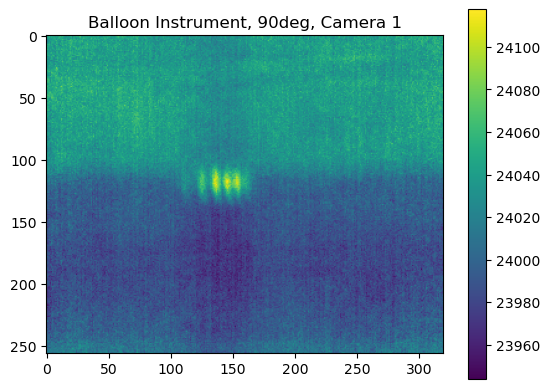

In [342]:
plt.style.use('default')

plt.imshow(img1[0])
plt.colorbar()
#plt.clim(24070,24240)
plt.title("Balloon Instrument, 90deg, Camera 1")

Text(0.5, 1.0, 'Balloon Instrument, 0deg, Camera 2')

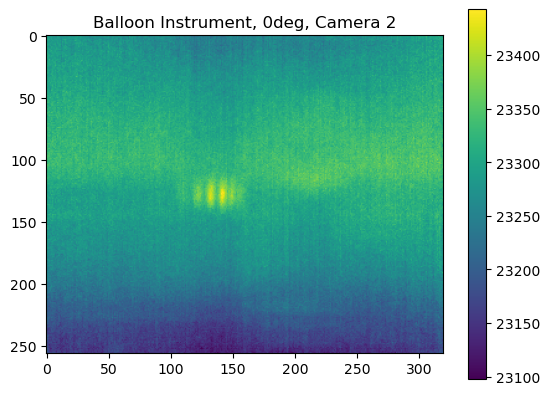

In [397]:
plt.style.use('default')

plt.imshow(img2[0])
plt.colorbar()
#plt.clim(23400,23700)
plt.title("Balloon Instrument, 0deg, Camera 2")

# Subtract background correction

In [344]:
im1 = []
im2 = []
for t in range(numangles):
    
#    c1 = (img1[t] - np.mean(img1[t][200:230,25:50]))    #3C
#    c2 = (img2[t] - np.mean(img2[t][200:230,25:50]))    
    
    c1 = (img1[t] - np.mean(img1[t][200:230,250:300]))    
    c2 = (img2[t] - np.mean(img2[t][160:170,145:155]))   
    
  # c1 = (img1[t] - np.mean(img1[t][160:170,145:155]))    
  # c2 = (img2[t] - np.mean(img2[t][200:256,120:160]))  
    
  #  c1 = (img1[t] - np.mean(img1[t][160:170,145:155]))    #13C
  #  c2 = (img2[t] - np.mean(img2[t][200:256,0:50]))    
    
    
    
    im1.append(c1)
    im2.append(c2)

In [345]:
def f(T, A, B): # this is your 'straight line' y=f(x)
    return A*T + B

def pixel_registration(array,cal_file,waves,ymin,ymax):
    #import cal file
    cal =  h5py.File(cal_file, "r")
    ROI =  list(cal['pixel_registration/ROI'])
    pa  =  list(cal['pixel_registration/fitparams'])

    array=array[ymin:ymax,ROI[0]:ROI[1]]
    
    new = np.zeros([len(array),len(waves)])
    for i in range(len(array)):
        for l in range(len(waves)):    
            w=  waves[l]
            j = int(round(f(w,pa[0],pa[1])))
            values = array[i,j-1:j+1]
            value = np.mean(values)
            new[i,l] = value
    return(new)

In [346]:
y2 = 130
y1 = 116

#center of spectral FOV

# Returns a reponse value for every angle and wavelength

In [347]:
responses = np.zeros([len(angles),len(waves)])
responses1 = np.zeros([len(angles),len(waves)])
responses2 = np.zeros([len(angles),len(waves)])
responses_err = np.zeros([len(angles),len(waves)])
responses_err1 = np.zeros([len(angles),len(waves)])
responses_err2 = np.zeros([len(angles),len(waves)])

for a in range(len(angles)):
    p2 = pixel_registration(im2[a],cal_file2,waves,ymin2,ymax2)
    p1 = pixel_registration(im1[a],cal_file1,waves,ymin1,ymax1)
    s2 = pixel_registration(std2[a],cal_file2,waves,ymin2,ymax2)
    s1 = pixel_registration(std1[a],cal_file1,waves,ymin1,ymax1)

    err = np.sqrt((s2[y2-ymin2])**2+(s1[y1-ymin1])**2)
    responses[a]= (p1[y1-ymin1]+p2[y2-ymin2])
    responses_err[a]= err
    
    responses1[a]= p1[y1-ymin1]
    responses_err1[a]= s1[y1-ymin1]
    responses2[a]= p2[y2-ymin2]
    responses_err2[a]= s2[y2-ymin2]

In [348]:
def transmission_correction(I1,I2,iterations):
    T = 1
    i = 0
    while i < iterations:
        t = np.mean(I1)/np.mean(I2) 
        T_update = T*t
        I2_update = t*I2
        I2 = I2_update
        T= T_update
        i = i+1;
    return([I1,I2,T])

In [349]:
R1 = responses1 
R2 = responses2
E1 = responses_err1
E2 = responses_err2

# Calculate the unpolarized transmission and aolp dependent transmission

In [350]:
t_unpol = np.mean(R1,axis = 0)/np.mean(R2,axis = 0) #average over all angles

transmission_aolp = np.zeros([len(angles),len(lambda_c)])
for a in range(len(angles)):
    I1 = R1[a]
    I2 = R2[a]
    for i in range(len(lambda_c)):
        v = transmission_correction(I1[pixel1[i]:pixel2[i]],I2[pixel1[i]:pixel2[i]],3)[2]
        transmission_aolp[a,i] = v

Text(0.5, 1.0, '23C')

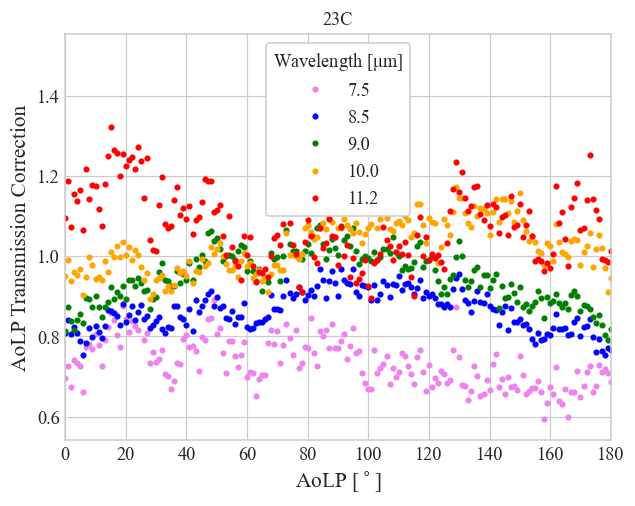

In [352]:
plt.style.use('seaborn-whitegrid')

textwidth = 5.9

#Plotting Options
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["font.family"] = "Times New Roman"

fig = fig = plt.gcf() 
plt.plot(angles,transmission_aolp[:,4],'.',color = 'violet',label = str(round(lambda_c[4],1)),alpha = 1)
plt.plot(angles,transmission_aolp[:,28],'.',color = 'blue',label = str(round(lambda_c[28],1)),alpha = 1)
plt.plot(angles,transmission_aolp[:,40],'.',color = 'green',label = str(round(lambda_c[40],1)),alpha = 1)
plt.plot(angles,transmission_aolp[:,64],'.',color = 'orange',label = str(round(lambda_c[64],1)),alpha = 1)
plt.plot(angles,transmission_aolp[:,94],'.',color = 'red',label = str(round(lambda_c[94],1)),alpha = 1)

plt.ylabel("AoLP Transmission Correction",fontsize = 14)
plt.xlabel('AoLP [$^\circ$]')

plt.xlim(0,180)
plt.gcf().set_dpi(110)

legend = plt.legend(title = 'Wavelength [$\mathdefault{\mu m}$]',framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
plt.title("23C")

In [353]:
#error propagation
def mod_uncertainty(x,y,sigma_x,sigma_y):
    dm_mI = (4*x**2)/(x+y)**4
    return (dm_mI*(sigma_x**2 + sigma_y**2))**0.5

# Apply transmission corrections and calculate modulation

In [1043]:
#calculate modulation function for calibration data
calibration_mod = np.zeros([len(angles),len(pixel_c)])
calibration_I1  = np.zeros([len(angles),len(pixel_c)])
calibration_I2  = np.zeros([len(angles),len(pixel_c)])
calibration_modE  = np.zeros([len(angles),len(pixel_c)])

for a in range(len(angles)):
    I1 = R1[a,pixel_c[0]:pixel_c[-1]+1]/t_unpol[pixel_c[0]:pixel_c[-1]+1]
    I2 = R2[a,pixel_c[0]:pixel_c[-1]+1]*transmission_aolp[a]
    e1 = E1[a,pixel_c[0]:pixel_c[-1]+1]
    e2 = E2[a,pixel_c[0]:pixel_c[-1]+1]
    
    mod_a = (I1-I2)/(I1+I2)
    mod_e = mod_uncertainty(I1,I2,e1,e2)
                            
    calibration_I1[a]  = I1
    calibration_I2[a]  = I2
    calibration_mod[a] = mod_a
    calibration_modE[a] = mod_e

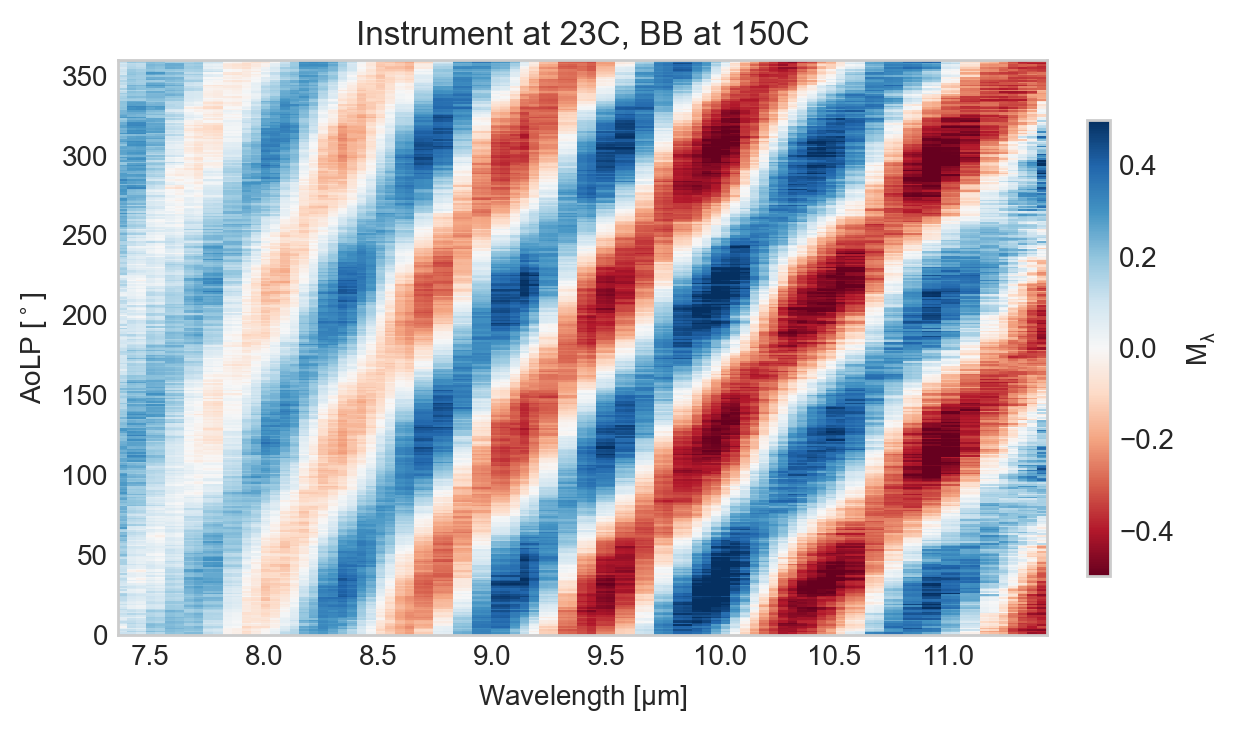

In [1044]:
fig =plt.gcf()
plt.gca().set_aspect(.007)
plt.pcolormesh(lambda_c[2:99],angles,calibration_mod[:,2:99],shading='auto',norm=colors.PowerNorm(gamma=1,vmin = -.5,vmax = .5),cmap = 'RdBu')
plt.colorbar(label = "$\mathdefault{M_\lambda}$",fraction=0.023, pad=0.04)
plt.gcf().set_dpi(200)
plt.xlabel('Wavelength [$\mathdefault{\mu}$m]')
plt.ylabel('AoLP [$^\circ$]')
plt.title("Instrument at 23C, BB at 150C")
plt.show()

In [777]:
from astropy.timeseries import LombScargle

In [778]:
wav=list(map(lambda l :1/(l*1.0e-4),lambda_c)) #cm
wavnums=list(map(lambda l :1/(l*1.0e-4),waves)) #cm
ret=list(map(lambda l :(retardance(l))*1.0e-4,lambda_c)) #cm

# Calibration data in Lomb Scargle Model

10.487394957983193
expected retardance 0.008944157276944795
False Alarm Probability = 2.0777292752610295e-07
best frequency = 0.010893002607939734
dolp = 0.4267351459323704
aolp = 70.29336906310256


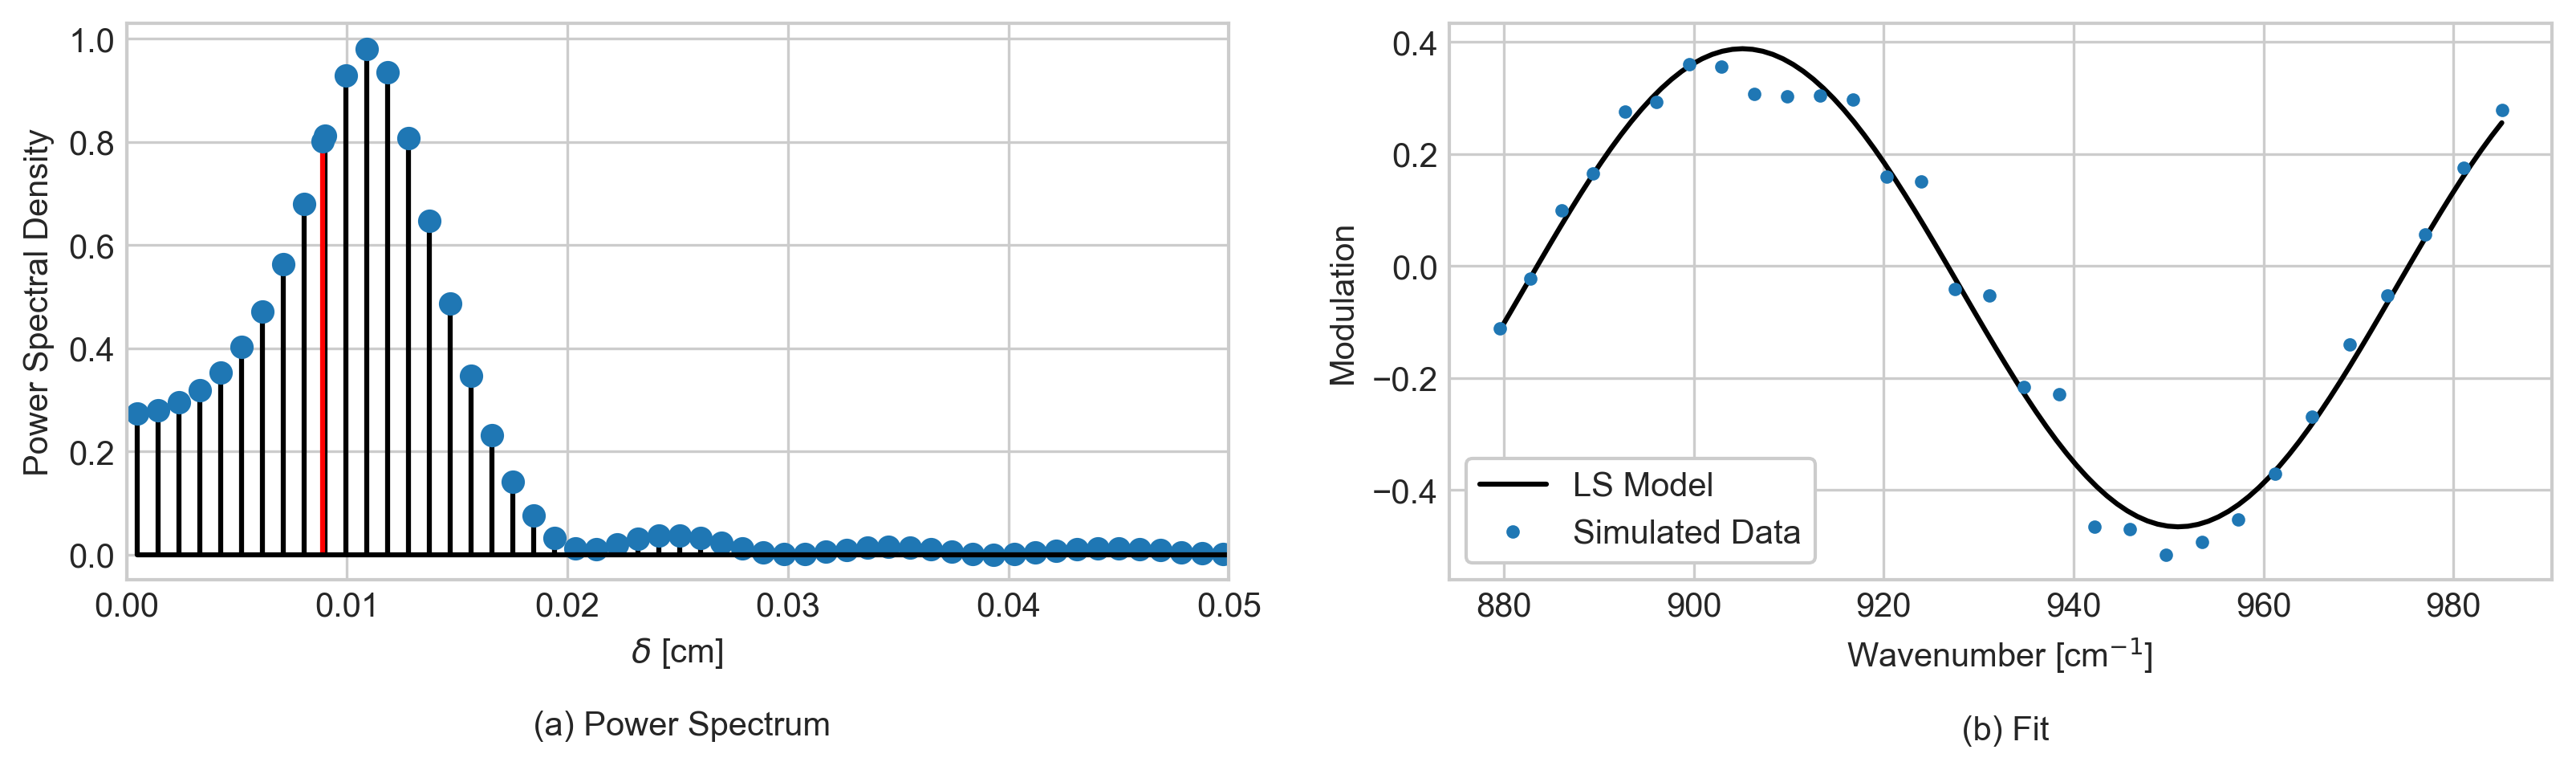

In [1061]:
a = 45
j = 76

plt.style.use('seaborn-whitegrid')

print(lambda_c[j])
print('expected retardance ' + str(ret[j]))
start = pixel1[j] #first pixel 
stop  = pixel2[j] #last pixel 
n = stop-start;

x = wav[start:stop] #select mod period
data = calibration_mod[a] 
data_err = calibration_modE[a] 

y = data[start:stop]
dy = data_err[start:stop]
#frequency = np.linspace(70,100,100)

ls = LombScargle(x, y)
frequency,power = LombScargle(x, y).autopower(minimum_frequency=ret[j+4],
                                              maximum_frequency=ret[j-4],samples_per_peak=10) #sampling in 1 period intervalsLombScargle(x, y,dy)
frequency_full,power_full = LombScargle(x, y).autopower(samples_per_peak=10) #calculate the full power spectrum



best_frequency = frequency_full[np.argmax(power_full)]
t_fit = np.linspace(x[-1],x[0],100)
y_fit = ls.model(t_fit, frequency_full[np.argmax(power_full)])

prob = ls.false_alarm_probability(power[np.argmax(power)])  
print('False Alarm Probability = ' + str(prob))

[offset,q,u] = ls.model_parameters(best_frequency)
print("best frequency = " + str(best_frequency))
U = u
Q = q
dolp = (((U)**2 +(Q)**2)**0.5)
aolp = 0.5*np.arctan2(U,Q)
print('dolp = ' + str(dolp))
print('aolp = ' + str(np.rad2deg(aolp)))

fig, axes = plt.subplots(1,2,figsize=(13, 3))
plt.gcf().set_dpi(300)
axes[0].stem(frequency_full, power_full, 'k',basefmt = 'k')
axes[0].stem(frequency, power, 'r',basefmt = 'k')
axes[0].set_xlim(0,.05)
axes[0].set_xlabel('$\delta$ [cm] \n \n (a) Power Spectrum')
axes[0].set_ylabel('Power Spectral Density')     

axes[1].plot(t_fit,y_fit,'k', label='LS Model')
axes[1].set_xlabel('Wavenumber [cm$^{-1}$] \n \n (b) Fit')
axes[1].set_ylabel('Modulation')
#axes[1].errorbar(x,y,yerr = dy,fmt='.', label='Simulated Data')
axes[1].plot(x,y,'.', label='Simulated Data')

legend = plt.legend(framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
plt.show()

In [1062]:
def LombFreq(j, data ):
    start = pixel1[j] #first pixel 
    stop  = pixel2[j] #last pixel 
    n = stop-start;

    x = wav[start:stop] #select mod period
    data = calibration_mod[a] 

    y = data[start:stop]
    dy = data_err
 #   frequency = np.linspace(70,100,100)

    ls = LombScargle(x, y)
    frequency,power = LombScargle(x, y).autopower(minimum_frequency=ret[j+4],
                                              maximum_frequency=ret[j-4],samples_per_peak=100)
    frequency_full,power_full = LombScargle(x, y).autopower(samples_per_peak=100) #calculate the full power spectrum

    best_frequency = frequency_full[np.argmax(power_full)]
    
    t_fit = np.linspace(x[-1],x[0],1000)
    y_fit = ls.model(t_fit, best_frequency) #plot on a finer grid
    
    amplitude = (y_fit.max()-y_fit.min())/2
    
    return(best_frequency, amplitude)

# Calculate efficiency

In [1063]:
efficiency = []

for j in range(0,90):

    powers = np.zeros(360)
    freqs = np.zeros(360)

    for a in range(360):
        data = calibration_mod[a]
        try:
            f , pwr = LombFreq(j, data)
            powers[a] = pwr
            freqs[a] = f
        except:
            pass

    x = np.linspace(0,2*np.pi,len(angles)) #select mod period
    y = powers
    ls = LombScargle(x, y)
    frequency,power = LombScargle(x, y).autopower(minimum_frequency=.1,
                                                  maximum_frequency=2) #sampling in 1 period intervalsLombScargle(x, y,dy)

    best_frequency = frequency[np.argmax(power)]
    t_fit = np.linspace(x[0],x[-1],360)
    y_fit = ls.model(t_fit, best_frequency)
    efficiency.append(y_fit)

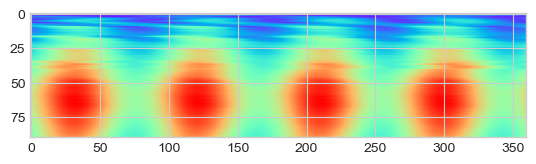

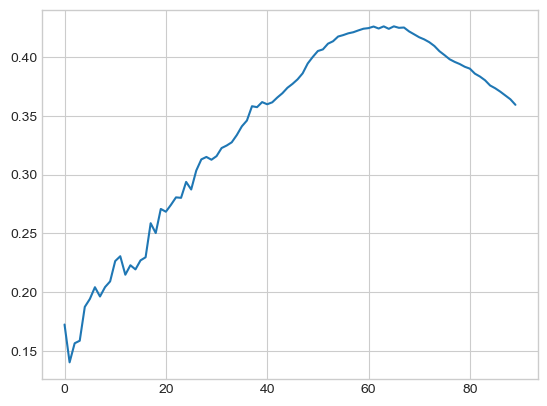

In [1064]:
efficiency = np.array(efficiency)
plt.imshow(efficiency,cmap = 'rainbow')
plt.show()
eff_ang = t_fit

W = np.mean(efficiency,axis = 1)
plt.plot(W)

In [1065]:
carrier = np.zeros(len(lambda_c))
for j in range(len(lambda_c)):
    freqs = np.zeros(360)
    for a in range(360):
        data = calibration_mod[a]
        try:
            f,p = LombFreq(j, data)
            freqs[a]= f
        except:
            freqs[a] = np.nan
    carrier[j] = np.median(freqs)

In [1066]:
def LombModel(a,j,thresh,W):
    start = pixel1[j]
    stop  = pixel2[j]
    n = stop-start;
 
    x = wav[start:stop] #select mod period
    data = calibration_mod[a] 
    y = data[start:stop]
    dy = data_err
 

    ls = LombScargle(x, y)
    frequency, power = ls.autopower(minimum_frequency=carrier[j]-.002,maximum_frequency=carrier[j]+.002) #sampling in 1 period intervalsLombScargle(x, y,dy)
    
    prob = ls.false_alarm_probability(power[np.argmax(power)])  
    if prob < thresh:
        [offset,q,u] = ls.model_parameters(carrier[j])
        U = u
        Q = q
        dolp = (((U)**2 +(Q)**2)**0.5)
        aolp = 0.5*np.arctan2(U,Q)
        aolp_corr = aolp - phase[j]
        eff = W[j,a]
        dolp_corr = dolp/eff
        if dolp > 1:
            [prob,U,Q] =[np.NAN,np.NAN,np.NAN]

    else:
        [prob,U,Q,dolp_corr,aolp_corr] =[np.NAN,np.NAN,np.NAN,np.NAN,np.NAN]
    
    return([dolp_corr,aolp_corr,Q,U,prob,np.NAN])

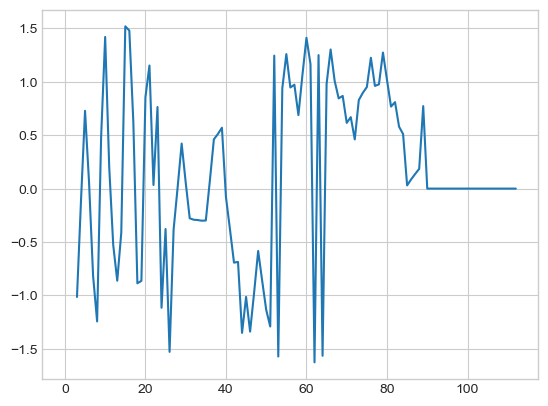

In [1072]:
offset = []
results = np.zeros([len(lambda_c),360,6])
for j in range(len(lambda_c)):
    
    for a in range(0,360):
        try:
            results[j,a] = LombModel(a,j,.1,efficiency)  
        except:
            w =1  
            
phase = results[:,0,1]
plt.plot(phase)

In [1073]:
aolp_cal1 = np.zeros([len(angles[:180])])
aolp_corr1 = np.zeros([len(angles[:180])])
dolp_cal1 = np.zeros([len(angles[:180])])
dolp_error1 = np.zeros([len(angles[:180])])
error1 = np.zeros([len(angles[:180])])

aolp_cal2 = np.zeros([len(angles[:180])])
aolp_corr2 = np.zeros([len(angles[:180])])
dolp_cal2 = np.zeros([len(angles[:180])])
dolp_error2 = np.zeros([len(angles[:180])])
error2 = np.zeros([len(angles[:180])])


j = 74
for a in range(180):
    try:
        out = LombModel(a,j,.1,efficiency)  
        dolp_cal1[a] = out[0]
        dolp_error1[a] = (out[0] - 1)
        aolp_cal1[a] = np.rad2deg(out[1])
        if aolp_cal1[a] > 0 and angles[a] > 170:
            aolp_corr1[a] = aolp_cal1[a] + 180
            error1[a] =  aolp_corr1[a]- angles[a] 
            pass
        if aolp_cal1[a] < 0:
            aolp_corr1[a] = aolp_cal1[a] + 180
            error1[a] =  aolp_corr1[a]- angles[a] 
            pass
        if aolp_cal1[a] > 0 and angles[a] < 170:
            aolp_corr1[a] = aolp_cal1[a]
            error1[a] =  aolp_corr1[a]- angles[a] 
            pass
    except:
        print('error')
    
j = 45
for a in range(180):
    try:
        out = LombModel(a,j,.1,efficiency)  
        dolp_cal2[a] = out[0]
        dolp_error2[a] = (out[0] - 1)
        aolp_cal2[a] = np.rad2deg(out[1])
        if aolp_cal2[a] > 0 and angles[a] > 170:
            aolp_corr2[a] = aolp_cal2[a] + 180
            error2[a] =  aolp_corr2[a]- angles[a] 
            pass
        if aolp_cal[a] < 0:
            aolp_corr2[a] = aolp_cal2[a] + 180
            error2[a] =  aolp_corr2[a]- angles[a] 
            pass
        if aolp_cal2[a] > 0 and angles[a] < 170:
            aolp_corr2[a] = aolp_cal2[a]
            error2[a] =  aolp_corr2[a]- angles[a] 
            pass
    except:
        print('error')
    


Text(0, 0.5, 'Retrieved AoLP')

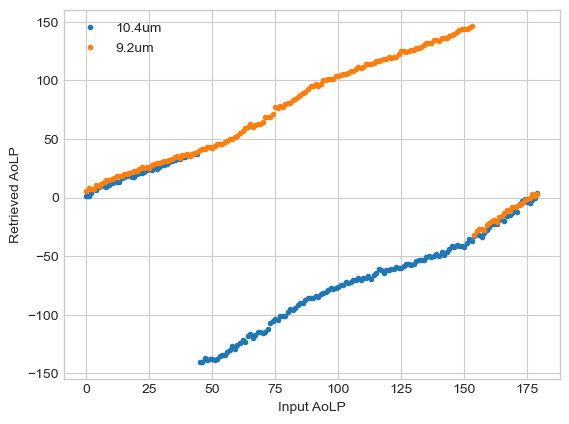

In [1076]:
plt.plot(angles[:180],aolp_cal1,'.',label = '10.4um')
plt.plot(angles[:180],aolp_cal2,'.',label = '9.2um')
plt.legend()
plt.xlabel('Input AoLP')
plt.ylabel('Retrieved AoLP')

Text(0, 0.5, 'Difference in Retrieved and Input AoLP')

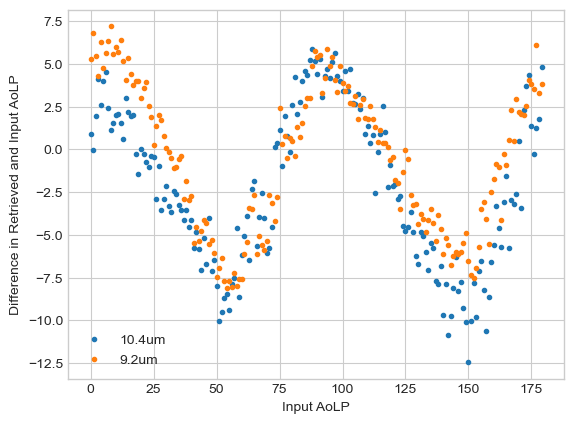

In [1077]:
plt.plot(angles[:180],error1,'.',label = '10.4um')
plt.plot(angles[:180],error2,'.',label = '9.2um')
plt.legend()
plt.xlabel('Input AoLP')
plt.ylabel('Difference in Retrieved and Input AoLP')

Text(0, 0.5, 'Retrieved DoLP')

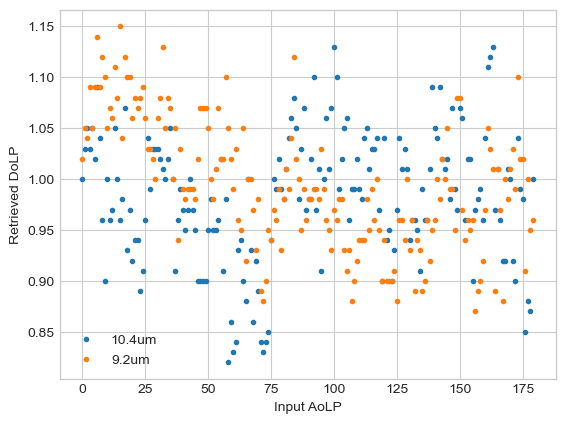

In [1078]:
plt.plot(angles[:180],np.round(dolp_cal1,2),'.',label = '10.4um')
plt.plot(angles[:180],np.round(dolp_cal2,2),'.',label = '9.2um')
plt.legend()
plt.xlabel('Input AoLP')
plt.ylabel('Retrieved DoLP')

## Radiometry

In [ ]:
LUT = 'C://Users//khart//Documents//Summer2022Campaign//IRCSP1//Water_Meas//7.14.2023//LUT//'

In [462]:
LUT = 'C://Users//khart//Documents//Summer2022Campaign//IRCSP1//Calibration//8.1.2022//LUT_compare//'

In [473]:
t = '23C//'

In [476]:
temps = np.arange(20, 150,5)
numtemps = len(temps)
imgs1 = np.zeros([numtemps,256,320])
imgs2 = np.zeros([numtemps,256,320])
std1 = np.zeros([numtemps,256,320])
std2 = np.zeros([numtemps,256,320])
t1 = np.zeros(numtemps)
t2 = np.zeros(numtemps)

In [477]:
for i in range(numtemps):
    with h5py.File(LUT + str(t) + str(round(temps[i],3))+'C.h5', "r") as f:

            imgs1[i] = np.mean(np.array(f[list(f.keys())[0]]),axis = 0)
            imgs2[i] = np.mean(np.array(f[list(f.keys())[1]]),axis = 0)
            std1[i] = np.array(f[list(f.keys())[2]])
            std2[i] = np.array(f[list(f.keys())[3]])
            t1[i] = np.array(f[list(f.keys())[4]])
            t2[i] = np.array(f[list(f.keys())[5]])


In [444]:
im1 = []
im2 = []
for t in range(numtemps):
    
    c1 = (imgs1[t] - np.mean(imgs1[t][160:170,145:155]))    
    c2 = (imgs2[t] - np.mean(imgs2[t][200:230,0:50]))    

    
    im1.append(c1)
    im2.append(c2)

In [445]:
def f(T, A, B): # this is your 'straight line' y=f(x)
    return A*T + B

def pixel_registration(array,cal_file,waves,ymin,ymax):
    #import cal file
    cal =  h5py.File(cal_file, "r")
    ROI =  list(cal['pixel_registration/ROI'])
    pa  =  list(cal['pixel_registration/fitparams'])

    array=array[ymin:ymax,ROI[0]:ROI[1]]
    
    new = np.zeros([len(array),len(waves)])
    for i in range(len(array)):
        for l in range(len(waves)):    
            w=  waves[l]
            j = int(round(f(w,pa[0],pa[1])))
            values = array[i,j-1:j+1]
            value = np.mean(values)
            new[i,l] = value
    return(new)

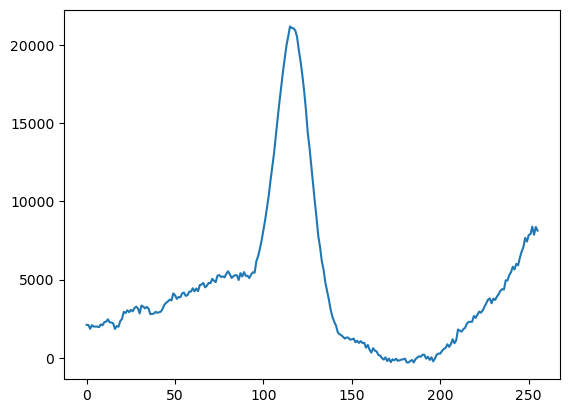

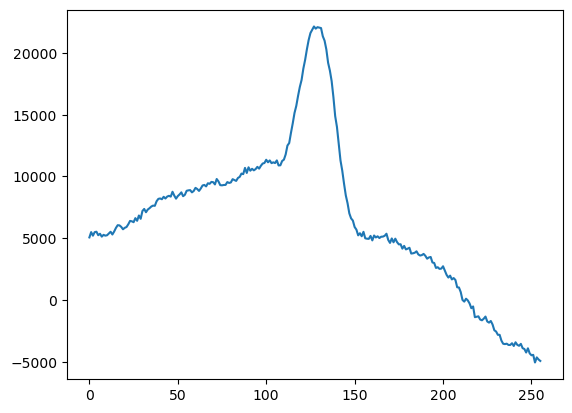

127
115


In [446]:
p1 = pixel_registration(im1[-1],cal_file1,waves,0,320)
p2 = pixel_registration(im2[-1],cal_file2,waves,0,320)
plt.plot(np.sum(p1,axis = 1))
plt.show()
plt.plot(np.sum(p2,axis = 1))
plt.show()
y2 = np.argmax(np.sum(p2,axis = 1))
print(y2)
y1 = np.argmax(np.sum(p1,axis = 1))
print(y1)

In [447]:
responses = np.zeros([len(temps),len(waves)])
responses1 = np.zeros([len(temps),len(waves)])
responses2 = np.zeros([len(temps),len(waves)])
responses_err = np.zeros([len(temps),len(waves)])
responses_err1 = np.zeros([len(temps),len(waves)])
responses_err2 = np.zeros([len(temps),len(waves)])

for t in range(len(temps)):
    p2 = pixel_registration(im2[t],cal_file2,waves,ymin2,ymax2)
    p1 = pixel_registration(im1[t],cal_file1,waves,ymin1,ymax1)
    s2 = pixel_registration(std2[t],cal_file2,waves,ymin2,ymax2)
    s1 = pixel_registration(std1[t],cal_file1,waves,ymin1,ymax1)

    err = np.sqrt((s2[y2-ymin2])**2+(s1[y1-ymin1])**2)
    responses[t]= (p1[y1-ymin1]+p2[y2-ymin2])
    responses_err[t]= err
    
    responses1[t]= p1[y1-ymin1]
    responses_err1[t]= s1[y1-ymin1]
    responses2[t]= p2[y2-ymin2]
    responses_err2[t]= s2[y2-ymin2]

In [450]:
x = []
for i in range(len(temps)):
    t = temps[i] + 273.15
    x.append(t)

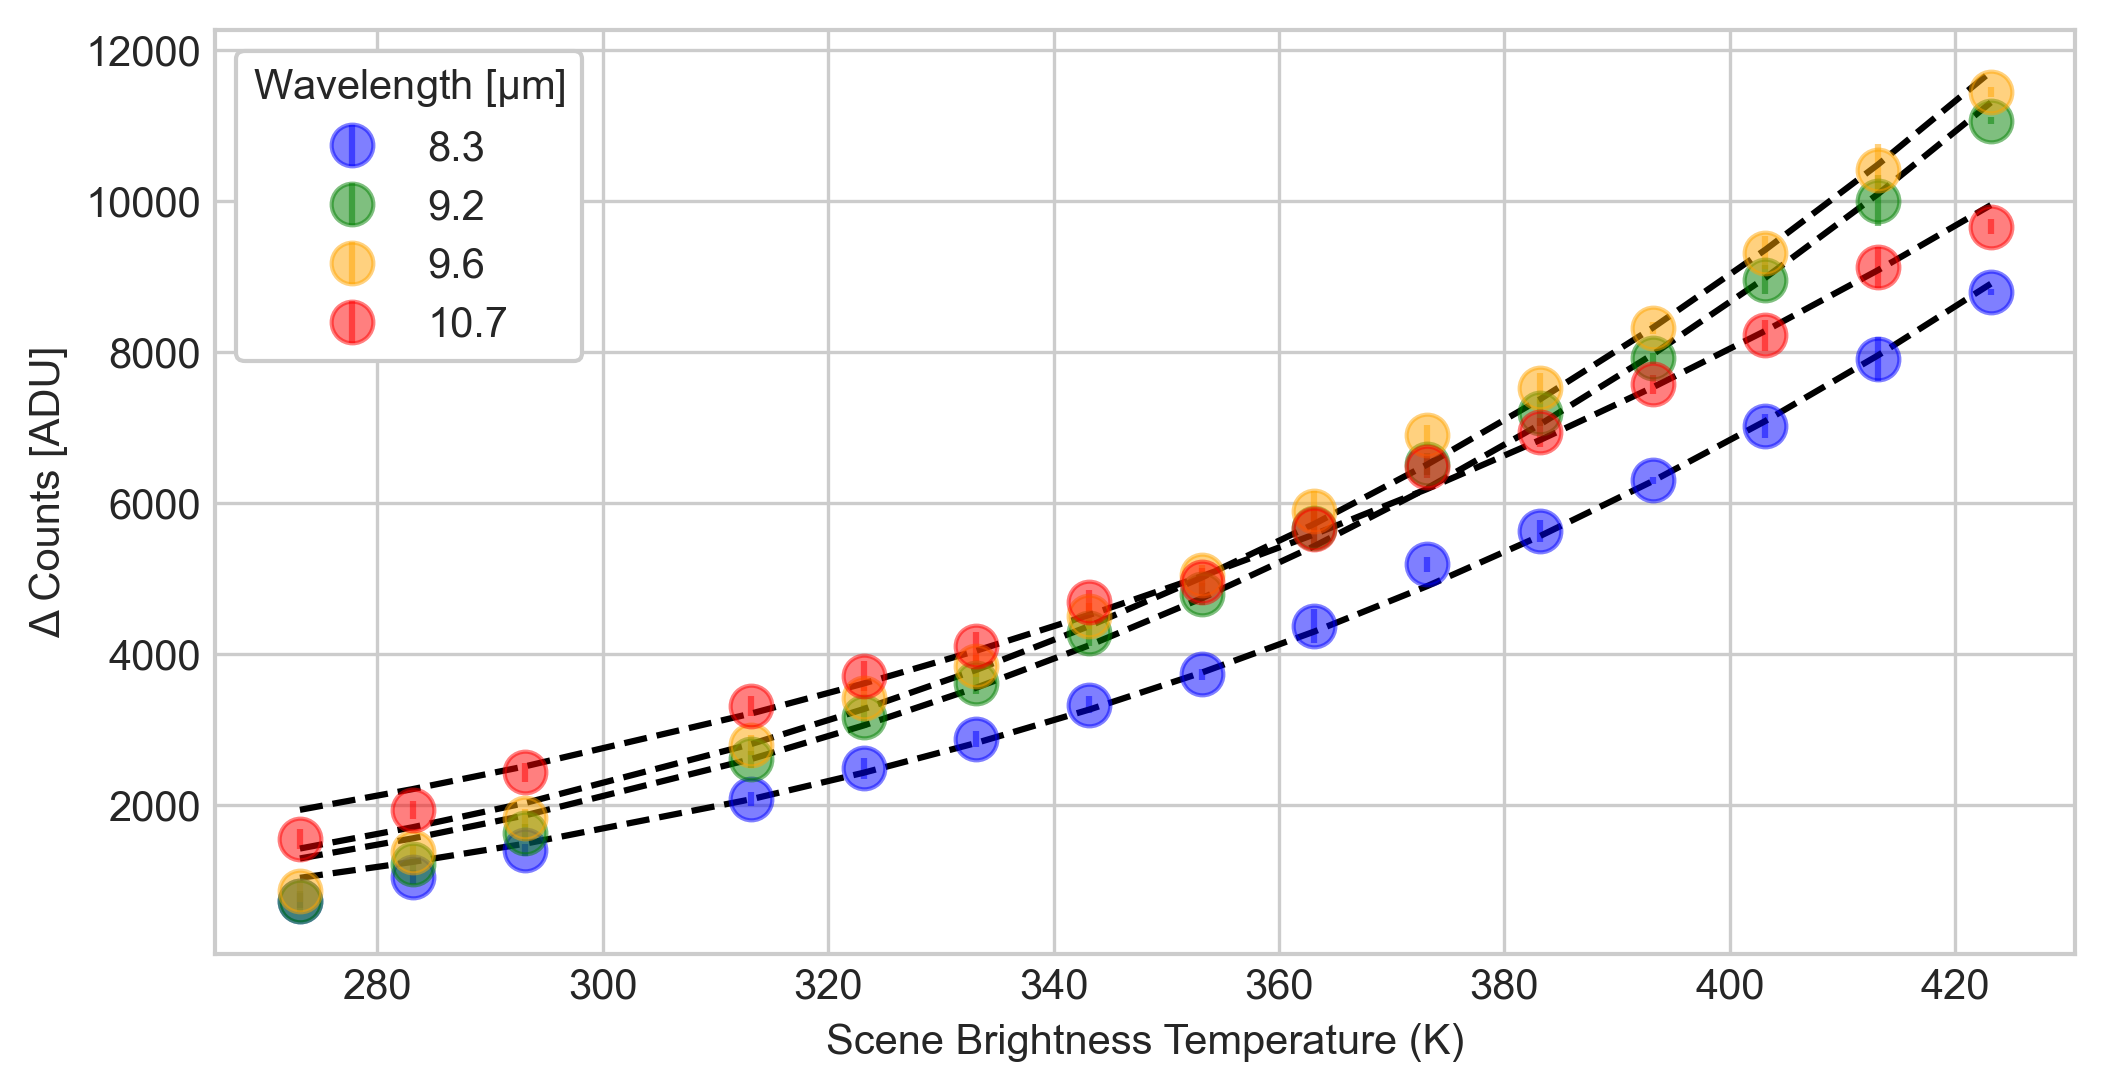

In [451]:
plt.style.use('seaborn-whitegrid')

""" Fitting Function"""
def func(x, a, b):
    y = a*(x-b)**4 
    return y

colors = ['blue','green','orange','red']
#temps = np.arange(40, 150,5)
fig = plt.subplots(figsize = [8,4])
plt.gcf().set_dpi(300)

nu = [24,46,54,80]
for i in range(4):
    
    ind = nu[i]
    start = pixel1[ind]
    stop  = pixel2[ind]

    #x = temps + 273.15
    y = np.sum(responses[:,start:stop],axis = 1)
    y_err = np.sum(responses_err[:,start:stop],axis = 1)
    x2 = np.arange(30,60) + 273.15 #needs to be in kelvin

    popt, pcov = curve_fit(func, x, y)
    
    plt.plot(x, func(x, *popt), 'k--')

    plt.errorbar(x,y,yerr = y_err,fmt='.',color = colors[i],alpha=0.5,markersize = 20,label = str(np.round(lambda_c[ind],1)))

plt.xlabel("Scene Brightness Temperature (K)")
plt.ylabel("\u0394 Counts [ADU]")
legend = plt.legend(title = 'Wavelength [$\mathdefault{\mu m}$]',framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
plt.show()


In [453]:
var = np.zeros([95,2])
covar = np.zeros([95,2])

for ind in range(95):
    start = pixel1[ind]
    stop  = pixel2[ind]
    
    #x = temps + 273.15
    y = np.sum(responses[:,start:stop],axis = 1)
    y_err = np.sum(responses_err[:,start:stop],axis = 1)

    popt, pcov = curve_fit(func, x, y, sigma = y_err, maxfev = 9000)

    var[ind] = popt
    covar[ind] = np.sqrt(np.diag(pcov))

In [454]:
temp = np.arange(0, 100,5) + 273.15
nedts = np.zeros([len(waves),len(temp)])
for i in range(95):
    for t in range(len(temp)):
        tem = temp[t]
        snr =  0
        delta = 0
        start = pixel1[i]
        stop  = pixel2[i]

        e = np.sum(responses_err[:,start:stop]/responses[:,start:stop]) 

        while snr < e:
            snr = np.abs(func(tem+delta/2,var[i,0],var[i,1])-func(tem-delta/2,var[i,0],var[i,1]))
            delta = delta +.001 


        nedts[i,t] = delta

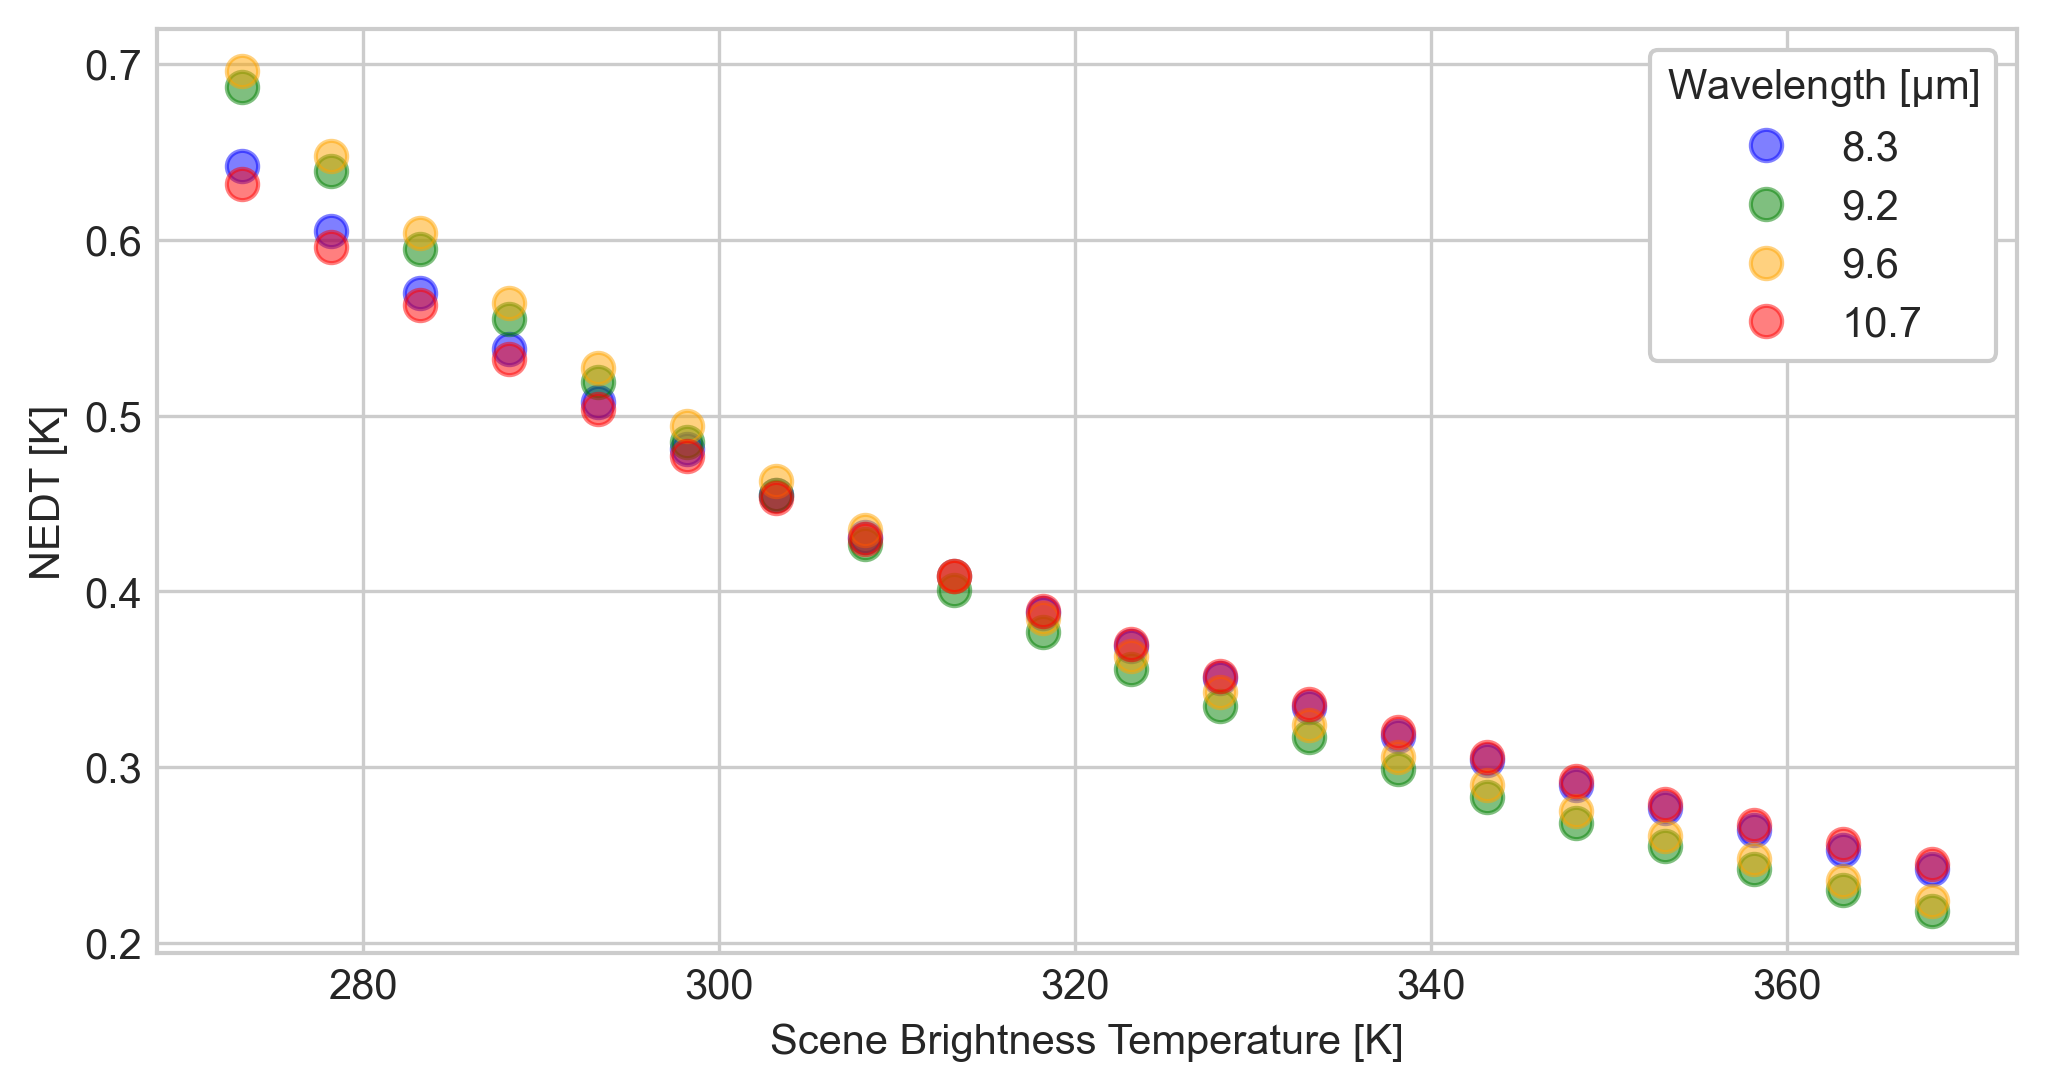

In [455]:
fig = plt.subplots(figsize = [8,4])
plt.gcf().set_dpi(300)
for i in range(4):
    ind = nu[i]
    plt.plot(temp,nedts[ind-10],'.',label = str(np.round(lambda_c[ind],1)), markersize = 15,color = colors[i],alpha = 0.5)
plt.legend( title='Wavelength [$\mathdefault{\mu}$m]')
plt.gcf().set_dpi(300)
plt.ylabel("NEDT [K]")
plt.xlabel("Scene Brightness Temperature [K]")

legend = plt.legend(title = 'Wavelength [$\mathdefault{\mu m}$]',framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
plt.show()

In [481]:
hf = h5py.File('C://Users//khart//Documents//Summer2022Campaign//IRCSP1//Water_Meas//7.14.2023//LUT//calibration.h5', 'w')
g = hf.create_group('pixel')
g.create_dataset('wavelength',data= lambda_c)
g.create_dataset('pixel1',data=pixel1)
g.create_dataset('pixel2',data=pixel2)

g = hf.create_group('transmission')
g.create_dataset('t_unpol',data= t_unpol)
g.create_dataset('t_pol', data=transmission_aolp)
g.create_dataset('angles',data=angles)

g = hf.create_group('polarization')
g.create_dataset('carrier',data= carrier)
g.create_dataset('W',data=efficiency)
g.create_dataset('W_ang',data=eff_ang)
g.create_dataset('phase',data=phase)
g.create_dataset('wavenums',data=wavnums)

g = hf.create_group('radiometric')
g.create_dataset('nedt',data= nedts)
g.create_dataset('var',data=var)
g.create_dataset('covar',data=covar)

hf.close()